Loaded pretrained weights for efficientnet-b7
병렬 처리 시간: 692.7859916687012초
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\uefa-champions-league-eps-vector-logo-400x400.png and target image: 1.0
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\warner-bros-black-vector-logo-400x400.png and target image: 0.8294266
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\maltese-cross-vector-logo-400x400.png and target image: 0.8116339
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\red-hot-chili-peppers-vector-logo-400x400.png and target image: 0.8069578
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\xxx-tv-vector-logo-400x400.png and target image: 0.79871374
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\kyocera-logo.png and target image: 0.79631644
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\Louis-Vuitton-vector-logo-download-400x400.png and target image: 0.7868867
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logo

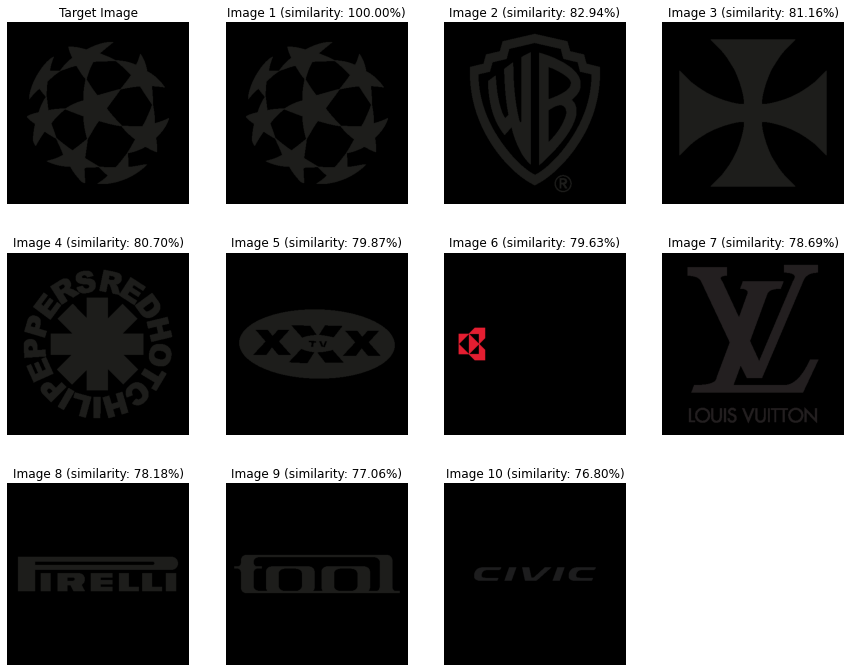

In [1]:
from efficientnet_pytorch import EfficientNet

#전체 이미지 DB에 있는 이미지들에서 유사도를 전부 측정한다.
def create_feature_extractor(model, return_nodes=None):
    if return_nodes is None:
        return_nodes = {'avgpool': 'avgpool'}

    return_nodes_output = {}
    for name, module in model.named_modules():
        if name in return_nodes:
            return_nodes_output[name] = module

    return return_nodes_output

model = EfficientNet.from_pretrained('efficientnet-b7')
model_features = create_feature_extractor(model,return_nodes={'avgpool':'avgpool'})
model.eval()    

import requests
import torchvision.transforms as T
from PIL import Image

def image_resize(image_url):                #이미지 url로 받아올 때 사용
    image = Image.open(requests.get(image_url, stream=True).raw)
    rgb_image = image.convert('RGB')
    preprocess = T.Compose([
        T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(224),
        T.ToTensor()]
    )
    return preprocess(rgb_image).unsqueeze(0)


from torchvision.transforms import Compose, Resize, ToTensor, Normalize

def image_resize_local(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error: Unable to open image. {e}")
        return None

    # 이미지 전처리: 크기 조정, 텐서 변환, 정규화
    preprocess = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    return preprocess(image)

from numpy import dot
from numpy.linalg import norm
import torch

def is_image_file(filename):
    # 파일 확장자 검사
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    _, ext = os.path.splitext(filename)
    return ext.lower() in VALID_EXTENSIONS

def cos_sim(A, B):
    return dot(A, B) / (norm(A) * norm(B))

def predict(image_path):
    resized_image = image_resize_local(image_path)
    if resized_image is None:
        return None
    model.eval()
    with torch.no_grad():
        image_transformed=resized_image.unsqueeze(0)
        predicted_result=model(image_transformed)
        image_feature=torch.flatten(predicted_result)
    return image_feature.detach().numpy()
    

root_dir = "C:\\Users\\DGU_ICE\\FindOwn\\ImageDB\\Logos"
#자신의 로컬에 있는 Image 파일 주소로 설정할 것.

import os
import re
from collections import defaultdict

# 타겟 이미지 경로
target_image_path = "C:\\Users\\DGU_ICE\\FindOwn\\ImageDB\\Logos\\manchester-city-logo-vector-download-400x400.jpg"

# 디렉토리에서 이미지 파일들 찾기
image_files = []
for (dirpath, dirnames, filenames) in os.walk(root_dir):
    for filename in filenames:
        if is_image_file(filename):
            image_files.append(os.path.join(dirpath, filename))

# 각 이미지와 타겟 이미지 간에 코사인 유사도 저장할 리스트 초기화
similarities = []

import cv2
import urllib.request
from matplotlib import pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# 타겟 이미지 특징 추출
def process_image(image_path):
    source_embedding = predict(image_path)
    if source_embedding is None or target_embedding is None:
        return image_path, None
    similarity = cos_sim(source_embedding,target_embedding)
    return image_path, similarity

import time
start_time=time.time()
target_embedding = predict(target_image_path)

# 각 이미지와 타겟 이미지의 유사도 계산
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_image, image_files))

# 유효한 결과만 저장하고 출력합니다.
top_results = []
for image_path, similarity in results:
    if similarity is not None:
        top_results.append((image_path, similarity))
    
top_results=sorted(top_results, key=lambda x: x[1],reverse=True)[:10]
elapsed_time = time.time() - start_time
print(f"병렬 처리 시간: {elapsed_time}초")
for image_path, similarity in top_results:
    print("Similarity between", image_path, "and target image:",similarity)


# # 유사도의 평균을 계산합니다
# average_similarity = sum(similarities) / len(similarities)
# print("Average similarity: {:.4f}%".format(round(average_similarity * 100,4)))

# import csv
# # CSV 파일을 쓰기 모드로 연다.
# with open('image_similarity_Top10image.csv', mode='w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow(['Image', 'Target Image', 'Similarity'])

#     for image_path, similarity in top_results:
#         # 유사도 값을 CSV 파일에 기록한다.
#         csv_writer.writerow([image_path, target_image_path, similarity * 100])

# 생성할 subplot의 행과 열 계산
n_rows = 3
n_cols = 4

# 하나의 figure에서 타겟 이미지와 top-10 이미지 출력
plt.figure(figsize=(15, 12))

# 타겟 이미지 출력
image = cv2.imread(target_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplot(n_rows, n_cols, 1)
plt.title("Target Image")
plt.imshow(image)
plt.axis('off')
top10_image_list=[]
# 상위 10개 이미지 출력
for i, (image_path, similarity) in enumerate(top_results):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    top10_image_list.append(image_path)
    plt.subplot(n_rows, n_cols, i + 2)
    plt.title(f"Image {i + 1} (similarity: {similarity * 100:.2f}%)")
    plt.imshow(image)
    plt.axis('off')

# plt.tight_layout()
plt.show()

Detected class: bench
Detection score : 0.4124286
Detected class C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\uefa-champions-league-eps-vector-logo-400x400.png : {'bench'}
Detection score : 0.4124286
Detected class C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\Louis-Vuitton-vector-logo-download-400x400.png : {'fire hydrant'}
Detection score : 0.46757734
Detected class C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\Louis-Vuitton-vector-logo-download-400x400.png : {'fire hydrant'}
Detection score : 0.45178455
bench 0
no images


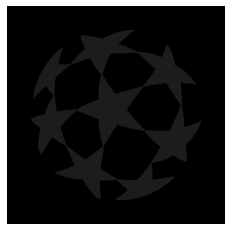

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import json
import matplotlib.pyplot as plt
import cv2

# Load the model
model = hub.load("https://tfhub.dev/tensorflow/efficientdet/d7/1")

# Load image and preprocess it
image = tf.image.decode_jpeg(tf.io.read_file(target_image_path))
if image.shape[-1] != 3:
    if image.shape[-1] == 1:
        # Convert grayscale to RGB
        image = tf.image.grayscale_to_rgb(image)
    elif image.shape[-1] == 4:
        # Convert RGBA to RGB by discarding the alpha channel
        image = image[..., :3]
        
image = tf.image.resize(image, [224, 224])
image = tf.cast(image, dtype=tf.uint8)

image = image[tf.newaxis, ...] # Add batch dimension and normalize

# Run detection
detections = model(image)

with open('coco-labels-2014_2017.txt','r') as f:
    mscoco_labels = [line.rstrip() for line in f]

# Print detected classes and bounding boxes
check = False
target_image_label = []
for i in range(int(detections['num_detections'])):
    score = detections['detection_scores'][0][i]
    
    # Only consider detections with a confidence score of at least 0.5
    if score >= 0.4:
        class_id = int(detections['detection_classes'][0][i])
        box = detections['detection_boxes'][0][i]

        label = mscoco_labels[class_id]
        check = True
        print(f"Detected class: {label}")
        target_image_label.append(label)
        print("Detection score :", score.numpy())
if check == False:
    print("No object detected")

##############top 10 images object detected##############
final_labels=[]

for i in range(len(top10_image_list)):
    image = tf.image.decode_jpeg(tf.io.read_file(top10_image_list[i]))
    if image.shape[-1] != 3:
        if image.shape[-1] == 1:
            # Convert grayscale to RGB
            image = tf.image.grayscale_to_rgb(image)
        elif image.shape[-1] == 4:
            # Convert RGBA to RGB by discarding the alpha channel
            image = image[..., :3]
            
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, dtype=tf.uint8)

    image = image[tf.newaxis, ...] # Add batch dimension and normalize

    # Run detection
    detections = model(image)
    check = False
    for j in range(int(detections['num_detections'])):
        score = detections['detection_scores'][0][j]
        
        # Only consider detections with a confidence score of at least 0.5
        if score >= 0.4:
            class_id = int(detections['detection_classes'][0][j])
            box = detections['detection_boxes'][0][j]
            label = mscoco_labels[class_id]
            check = True
            print(f"Detected class",top10_image_list[i],":" ,{label})
            final_labels.append(label)
            print("Detection score :", score.numpy())
    
endpoint = 0
final_result_images_index = []
for i in range(len(final_labels)):
    if final_labels[i] in target_image_label:
        print(final_labels[i],i)
        final_result_images_index.append(i)

if endpoint == 0:
    print("no images")
    
plt.imshow(cv2.imread(target_image_path))
for i in range(len(final_result_images_index)):
    plt.imshow(cv2.imread(top10_image_list[final_result_images_index[i]]))
plt.axis('off')
plt.show()

